In [29]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import  MinMaxScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score

import joblib # Save and load preprocessing pieline and models
import json


scaler_minmax= MinMaxScaler()                                                             # Create a MinMaxScaler object
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore',drop='first')            # Create a OneHotEncoder object


# Read CSV files

df=pd.read_csv("Training_Set_Values.csv")       # Read the Training data CSV file
name_featrures=df.columns                       # Get the features name
len_features=len(name_featrures)                # Get the length of features
labels=pd.read_csv("Training_Set_Labels.csv")   # Read the labels (target) CSV file
labels.head()
df['target'] = labels['status_group']           # Add the target column to the dataframe
#print(df.shape)                                 # Print the shape of the dataframe
#df.head()
#df.info()


In [30]:
df['construction_year'].describe()

#(dropna=False)

count    59400.000000
mean      1300.652475
std        951.620547
min          0.000000
25%          0.000000
50%       1986.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64

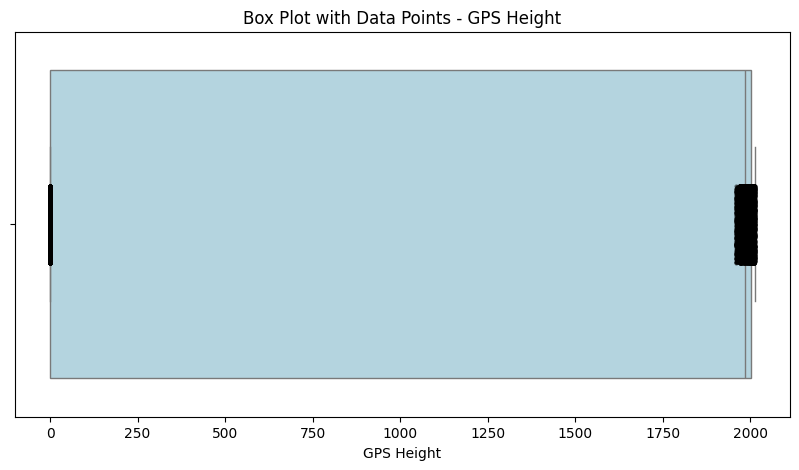

In [31]:
df['construction_year'].unique()
df['construction_year'].value_counts()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['construction_year'], color='lightblue')
sns.stripplot(x=df['construction_year'], color='black', size=3, jitter=True, alpha=0.5)

plt.title('Box Plot with Data Points - GPS Height')
plt.xlabel('GPS Height')
plt.show()




In [32]:
df['latitude'].max()


np.float64(-2e-08)

In [33]:
# Columns to be dropped for the baseline models
columns_drop=['id','amount_tsh','num_private','subvillage','recorded_by','scheme_name',
              'extraction_type_group','extraction_type_class',
              'management','payment_type','quality_group','quantity_group','source','waterpoint_type_group',
              'funder','installer','wpt_name','ward','scheme_management']

df = df.drop(columns=columns_drop)
print('Shape after dropping columns:', df.shape)

Shape after dropping columns: (59400, 22)


In [34]:
# Convert the target column to labels 
#print(df['target'].unique())
target_map_dict={'functional': 2, 'functional needs repair': 1, 'non functional': 0} # Defined the mapping of labels to numbers (integers)
#print(df['target'].head())
df['target'] =df['target'].map(target_map_dict) # transform the target column (labels) to  numbers (integers)
#df['target'].head()

In [35]:
# Separate features and target and perform train test split
X = df.drop(columns=['target'])  # Features only
y = df['target']                 # Target column
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.04, random_state=42, stratify=y)  # 2376 records for the test

# Save test data
joblib.dump(X_test, "X_test.pkl")
joblib.dump(y_test, "y_test.pkl")

['y_test.pkl']

In [36]:
type(y_test), type(X_test)
print(X_test.index.equals(y_test.index))  # should be True
y_test.head()

True


54918    2
25673    0
50464    0
58269    0
45655    0
Name: target, dtype: int64

In [37]:
# Import the custom transformers form helper_function.py
# The helper_function.py file contains the definitions for StringConverter, YearExtractor, IQRCapper, and ConstructionYearTransformer
from helper_function import (
    StringConverter,
    YearExtractor,
    IQRCapper,
    ConstructionYearTransformer,
    ObjectToNumericConverter
)
    
#pipeline transformers
date_recorded_transformer_pipeline=Pipeline([
    
    ('year_extractor',YearExtractor()),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore',drop='first'))
])


oulier_minmax_pipeline_clip = Pipeline(steps=[
    ('iqr_cap', IQRCapper(strategy='clip')),
    ('scaler', MinMaxScaler())
])

oulier_minmax_pipeline_mean = Pipeline(steps=[
    ('iqr_cap', IQRCapper(strategy='mean')),
    ('scaler', MinMaxScaler())
])

oulier_minmax_pipeline_median = Pipeline(steps=[
    ('iqr_cap', IQRCapper(strategy='median')),
    ('scaler', MinMaxScaler())
])


cat_pipeline = Pipeline([
     ('string_converter', StringConverter()),
    #('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore',drop='first'))
])

constructionyear_pipeline = Pipeline(steps=[
    ('replace_zeros_with_median', ConstructionYearTransformer()),
    ('minmax_scaling', MinMaxScaler())
])

categorical_columns=['basin','region','region_code','district_code','lga','public_meeting','permit','extraction_type',
                                    'management_group','payment','water_quality','quantity','source_type','source_class',
                                    'waterpoint_type']
# Extract unique categories for each categorical column
categories = {}
for col in categorical_columns:
    unique_categories = df[col].unique().tolist()
    # Convert to string and remove None if needed (NaN will be handled by pipeline)
    categories[col] = sorted(unique_categories)

# Save categories to a JSON file
with open("categories.json", "w") as f:
    json.dump(categories, f, indent=2)

print("Categories saved to categories.json")

# ColumnTransformer and full pipeline setup for feature preprocessing
# The ColumnTransformer allows us to apply different preprocessing steps to different columns of the DataFrame
preprocessor = ColumnTransformer(
    transformers=[
        ('date', date_recorded_transformer_pipeline, ['date_recorded']),
        #('gps_height', scaler_minmax, ['gps_height']),
        ('outlier_minmax_gps_height', oulier_minmax_pipeline_mean, ['gps_height']),
        ('outlier_minmax_longitude', oulier_minmax_pipeline_mean, ['longitude']),
        ('outlier_minmax_latitude', oulier_minmax_pipeline_mean, ['latitude']),
         ('cat_ohe', cat_pipeline, categorical_columns),
        ('outlier_minmax_population', oulier_minmax_pipeline_clip, ['population']),
        ('constructionyear', constructionyear_pipeline, ['construction_year'])


    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)



preprocess_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('object_to_numeric', ObjectToNumericConverter())  # your custom step
])


X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
# Save the preprocessor (this is done only once)
joblib.dump(preprocessor, "preprocessor.joblib")

Categories saved to categories.json


['preprocessor.joblib']

In [38]:
# models (Decision Tree, Random Forest, XGBoost) to be used
models = {    
    "DecisionTree": DecisionTreeClassifier(
        max_depth=10,  # You can tune this
        random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=100,
        max_depth=15,  # You can tune this too
        random_state=42
    ),"XGBoost": XGBClassifier(
        n_estimators=100,
        max_depth=11,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.8,
        #use_label_encoder=False,
        eval_metric='mlogloss',    # good for multi-class
        objective='multi:softmax', # directly outputs class labels
        num_class=3,               # number of target classes
        random_state=42
    )
}



# Results and feature importances storage
results = {}
feature_importances = {}

# Loop through each model
for name, model in models.items():
    model.fit(X_train_transformed, y_train)  # Fit the model on the transformed training data
    # Save the trained model for later use
    joblib.dump(model, f"{name}_model.joblib")
    # Predictions
    y_train_pred = model.predict(X_train_transformed)
    y_test_pred =  model.predict(X_test_transformed)

    # Accuracy scores
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    results[name] = {
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy
    }
    
    # Extract feature importances  
    if hasattr(model, 'feature_importances_'):
        # Get transformed feature names from preprocessor
        feature_names = preprocessor.get_feature_names_out()
        importances = model.feature_importances_
        feature_importances[name] = sorted(
            zip(feature_names, importances),
            key=lambda x: x[1],
            reverse=True
        )

# Print results
print("\nModel Comparison:")
print("{:<15} {:<15} {:<15}".format("Model", "Train Acc", "Test Acc"))
print("-" * 45)
for model_name, scores in results.items():
    print("{:<15} {:<15.4f} {:<15.4f}".format(model_name, scores["Train Accuracy"], scores["Test Accuracy"]))

# Print top features
print("\nTop 10 Important Features:")
for model_name, importance_list in feature_importances.items():
    print(f"\n{model_name}:")
    for feature, importance in importance_list[:10]:
        print(f"{feature:<30} {importance:.4f}")



Model Comparison:
Model           Train Acc       Test Acc       
---------------------------------------------
DecisionTree    0.7672          0.7496         
RandomForest    0.8141          0.7765         
XGBoost         0.8607          0.8068         

Top 10 Important Features:

DecisionTree:
waterpoint_type_other          0.2024
quantity_seasonal              0.1305
quantity_enough                0.1124
quantity_insufficient          0.0861
longitude                      0.0624
construction_year              0.0595
latitude                       0.0408
waterpoint_type_communal standpipe multiple 0.0378
population                     0.0175
gps_height                     0.0145

RandomForest:
quantity_enough                0.0745
longitude                      0.0676
waterpoint_type_other          0.0663
latitude                       0.0649
construction_year              0.0643
extraction_type_other          0.0635
gps_height                     0.0393
population                

In [39]:
"""
Model Comparison:
Model           Train Acc       Test Acc       
---------------------------------------------
Decision Tree   0.7672          0.7496         
Random Forest   0.8141          0.7765         
XGBoost         0.8607          0.8068  
"""


'\nModel Comparison:\nModel           Train Acc       Test Acc       \n---------------------------------------------\nDecision Tree   0.7672          0.7496         \nRandom Forest   0.8141          0.7765         \nXGBoost         0.8607          0.8068  \n'

In [40]:
# Testing the model on one sample form the test data
import random

# Load preprocessor and a trained model (e.g., RandomForest)
preprocessor = joblib.load("preprocessor.joblib")
model = joblib.load("RandomForest_model.joblib")  # Change to desired model: let say I chose RandomForest form list: [DecisionTree, RandomForest and XGBoost]
# Pick a random index from the test set
random_index = random.randint(0, len(X_test) - 1)
X_test_sample=X_test.iloc[[random_index]]  # extra [] is sued to get the dataframe not a series as our pipeline expects dataframe as input
y_test_sample=y_test.iloc[random_index]
# Preprocess the test sample
X_test_sample_transformed = preprocessor.transform(X_test_sample)
y_test_sample_pred = model.predict(X_test_sample_transformed)

Result={'Index': random_index,'True label': int(y_test_sample), 'Predicted label': int(y_test_sample_pred)}
Result_df = pd.DataFrame([Result])
Result_df

C:\Users\hp\AppData\Local\Temp\ipykernel_22072\1964544937.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Result={'Index': random_index,'True label': int(y_test_sample), 'Predicted label': int(y_test_sample_pred)}


,Index,True label,Predicted label
0,999,0,0


In [41]:
X_test_sample

,date_recorded,gps_height,longitude,latitude,basin,region,region_code,district_code,lga,population,...,permit,construction_year,extraction_type,management_group,payment,water_quality,quantity,source_type,source_class,waterpoint_type
11642,2011-07-23,0,33.835839,-9.540205,Lake Nyasa,Mbeya,12,3,Kyela,0,...,True,0,gravity,user-group,never pay,soft,dry,spring,groundwater,communal standpipe


In [42]:
X_test_sample_transformed

array([[0.        , 0.        , 0.03146853, 0.393806  , 0.18105891,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  